## Loss

In [1]:
import matplotlib.pyplot as plt
from utils import Extractor

In [48]:
def plot_hist(path0, path1):
    exts = [Extractor(path0), Extractor(path1)]
    plt.figure(figsize=(16,3)); plt.subplot(1,3,1); plt.ylim([155, 180])
    for depth, ext in enumerate(exts):
        plt.plot(ext("test", "x_loss")[10:], label=depth)
    plt.legend(); plt.subplot(1,3,2); plt.ylim([0, 5])
    for depth, ext in enumerate(exts):
        plt.plot(ext("test", "s_loss")[10:], label=depth)
    plt.legend(); plt.subplot(1,3,3); plt.ylim([10, 30])
    for depth, ext in enumerate(exts):
        plt.plot(ext("test", "s_aux_loss")[10:], label=depth)
    plt.legend(); plt.show()

## Pred expert observation
- 何step予測をする？？ not 300 good 50

In [89]:
import gym
from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
from rlkit.envs.wrappers import NormalizedBoxEnv

import argparse
import os
import pickle
import sys
sys.path.append("../")
from model import SSM
from utils import load_model


def eval_expert_loss(timestamp, load_epoch, param_path, data_path, N=10, H=50, show=False):
    parser = argparse.ArgumentParser()
    parser.add_argument("--device", type=int, nargs="+", default=[0])
    parser.add_argument("--s_dim", type=int, default=64)
    parser.add_argument("--a_dim", type=int, default=6)
    parser.add_argument("--o_dim", type=int, default=17)
    parser.add_argument("--h_dim", type=int, default=128)
    parser.add_argument("--timestamp", type=str, default=None)
    parser.add_argument("--load_epoch", type=int, default=None)
    args = parser.parse_args("\
        --device 0 \
        --timestamp {} \
        --load_epoch {} \
        ".format(timestamp, load_epoch).split())

    model = SSM(args)
    load_model(model, model_dir="../", epoch=args.load_epoch)

    with open(param_path, mode='rb') as f:
        a_mean, a_std, o_mean, o_std = pickle.load(f)

    with open(data_path, mode='rb') as f:
        data = pickle.load(f)

    traj_a = np.array([data[i][0] for i in range(len(data))],
                      dtype=np.float32)
    traj_o = np.array([data[i][1] for i in range(len(data))],
                      dtype=np.float32)
    # print(traj_a.shape, traj_o.shape)

    scores = []

    for trial in range(N):
        epis_a = traj_a[trial]
        epis_o = traj_o[trial]
        o, true = epis_o[0], epis_o[1:H+1]

        pred = []

        o = o.astype(np.float32)
        o = (o - o_mean) / o_std
        o = torch.from_numpy(np.array([o]))
        y = model.reset(o)

        for t in range(1, H+1):
            a = epis_a[t]
            a = a.astype(np.float32)
            a = (a - a_mean) / a_std
            a = torch.from_numpy(np.array([a]))
            y = model.step(a)[0]
            y = y.cpu().detach().numpy()
            # y = y * o_std + o_mean

            pred.append(y)

        if trial == 0 and show:
            for k in range(len(pred[0])):
                print(k)
                plt.figure(figsize=(12,1))
                plt.plot(np.array(true)[:,k], c='b', label='true')
                plt.plot(np.array(pred)[:,k], c='r', label='pred')
                plt.legend()
                plt.show()

        true = (true - o_mean) / o_std
        # plt.figure(figsize=(12,2))
        # plt.plot(true[:100][10]); plt.plot(pred[:100][10]); plt.show()
        # use angle (rad) only
        # score = np.mean(np.sum(np.power(np.array(pred - true)[:,1:8], 2), axis=1))
        # use angular velocity (rad/s) only
        # score = np.mean(np.sum(np.power(np.array(pred - true)[:,10:17], 2), axis=1))
        score = np.mean(np.sum(np.power(np.array(pred - true), 2), axis=1))
        scores.append(score)

    return np.mean(scores), np.std(scores)

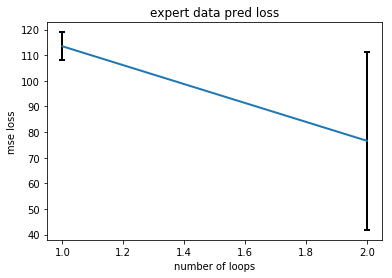

In [74]:
mean_hist = []
std_hist = []
mean, std = eval_expert_loss(
    "Feb26_08-06-04",
    2000,
    "../data/loop0/param.pkl",
    "../data/data_expert.pkl",
    N=100,
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb27_09-34-00",
    2000,
    "../data/loop1/param.pkl",
    "../data/data_expert.pkl",
    N=100,
)
mean_hist.append(mean)
std_hist.append(std)


plt.errorbar([i+1 for i in range(len(mean_hist))],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("number of loops")
plt.ylabel("mse loss")
plt.show()

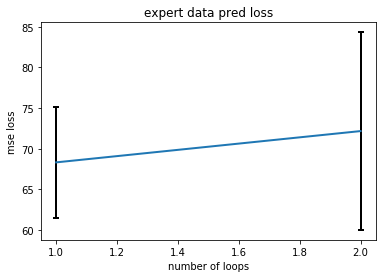

In [75]:
mean_hist = []
std_hist = []
mean, std = eval_expert_loss(
    "Feb28_14-10-06",
    2000,
    "../data/loop0_abci/param.pkl",
    "../data/data_expert.pkl",
    N=100,
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb28_17-33-18",
    2000,
    "../data/loop1_abci/param.pkl",
    "../data/data_expert.pkl",
    N=100,
)
mean_hist.append(mean)
std_hist.append(std)

plt.errorbar([i+1 for i in range(len(mean_hist))],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("number of loops")
plt.ylabel("mse loss")
plt.show()

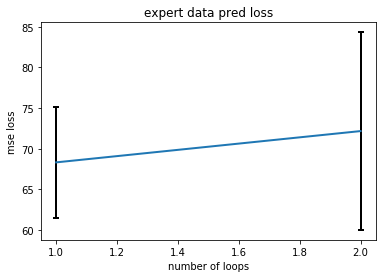

In [75]:
mean_hist = []
std_hist = []
mean, std = eval_expert_loss(
    "Feb28_14-10-06",
    2000,
    "../data/loop0_abci/param.pkl",
    "../data/data_expert.pkl",
    N=100,
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb28_17-33-18",
    2000,
    "../data/loop1_abci/param.pkl",
    "../data/data_expert.pkl",
    N=100,
)
mean_hist.append(mean)
std_hist.append(std)

plt.errorbar([i+1 for i in range(len(mean_hist))],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("number of loops")
plt.ylabel("mse loss")
plt.show()

### 反復学習0

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

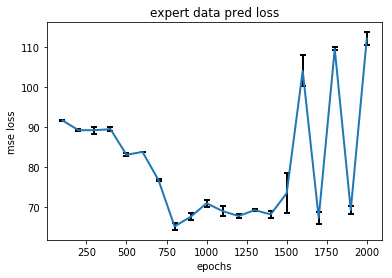

In [66]:
timestamp = "Feb26_08-06-04"
param_path = "../data/loop0/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(20):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*100, param_path, data_path, N=2)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*100 for i in range(20)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

### 反復学習1

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

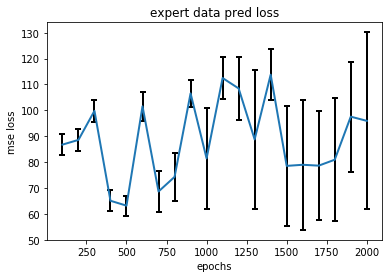

In [68]:
timestamp = "Feb27_09-34-00"
param_path = "../data/loop1/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []

for i in range(20):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*100, param_path, data_path, N=10)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*100 for i in range(20)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

### 反復学習2

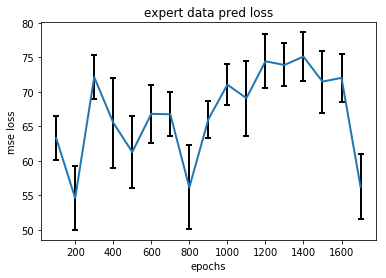

In [32]:
timestamp = "Mar01_04-57-45"
param_path = "../data/loop2_abci/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist = []
std_hist = []
# score = eval_expert_loss(timestamp, 1000, param_path, data_path, show=True)
# print(score)

for i in range(17):
    print(i, end=" ")
    mean, std = eval_expert_loss(timestamp, (i+1)*100, param_path, data_path, N=2)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*100 for i in range(17)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

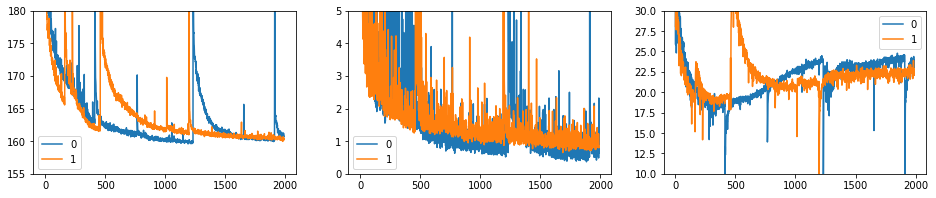

In [49]:
plot_hist("../../many_msl/MSL2/logzero/Mar01_09-11-51.txt", "../../many_msl/MSL2/logzero/Mar01_11-44-03.txt")

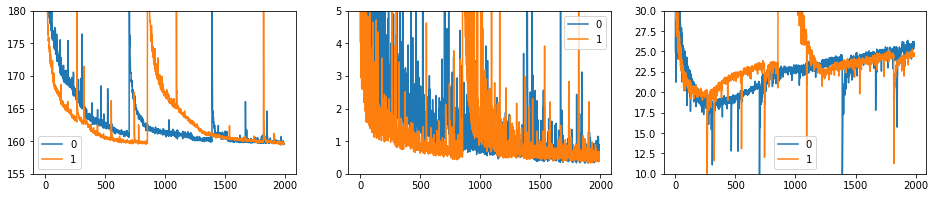

In [50]:
plot_hist("../../many_msl/MSL3/logzero/Mar01_09-03-58.txt", "../../many_msl/MSL3/logzero/Mar01_11-39-20.txt")

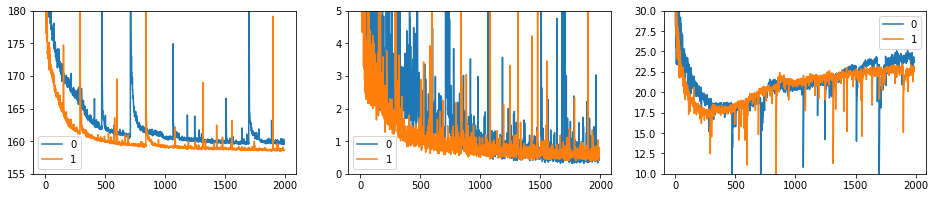

In [51]:
plot_hist("../../many_msl/MSL4/logzero/Mar01_09-05-36.txt", "../../many_msl/MSL4/logzero/Mar01_11-26-46.txt")

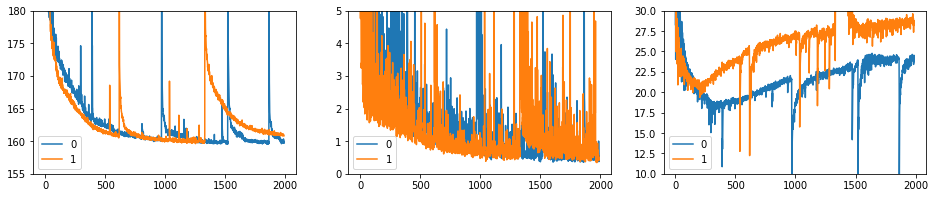

In [52]:
plot_hist("../../many_msl/MSL5/logzero/Mar01_09-06-36.txt", "../../many_msl/MSL5/logzero/Mar01_11-33-32.txt")

In [143]:
type("sss") is str

True

0 1 2 3 4 5 6 7 8 9 24.15586
0 1 2 3 4 5 6 7 8 9 37.10501
0 1 2 3 4 5 6 7 8 9 26.495953


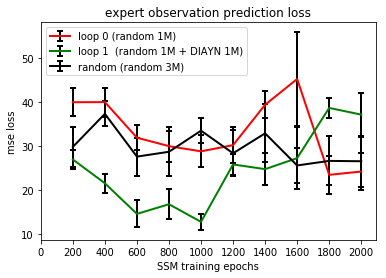

In [145]:
hists = [
    ["Feb28_14-10-06", "../data/loop0_abci/param.pkl", "loop 0 (random 1M)", 'r'],
    ["Feb28_17-33-18", "../data/loop1_abci/param.pkl", "loop 1  (random 1M + DIAYN 1M)", 'g'],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)", 'k']
]
compare_expert_loss_hist(hists, "../data/loop0/test.pkl", N=10)

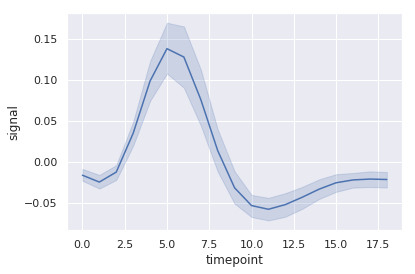

In [180]:
import seaborn as sns; sns.set()
fmri = sns.load_dataset("fmri")
sns.lineplot(x="timepoint", y="signal", data=fmri)
from matplotlib import colors as mcolors
colors = list(mcolors.TABLEAU_COLORS)

In [181]:
colors

['tab:blue',
 'tab:orange',
 'tab:green',
 'tab:red',
 'tab:purple',
 'tab:brown',
 'tab:pink',
 'tab:gray',
 'tab:olive',
 'tab:cyan']

In [231]:
def compare_expert_loss_hist(hists, data_paths, N=10, H=50, title="expert observation prediction loss", 
                            use_error=True, show=True):
    if type(data_paths) is str:
        data_paths = [data_path for _ in range(len(hists))]
    else:
        assert len(hists) == len(data_paths)

    mean_hists = []
    for k, hist in enumerate(hists):
        timestamp, param_path, label = hist

        mean_hist = []
        std_hist = []

        for i in range(10):
            print(i, end=" ")
            if not i == 9:
                continue
            mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_paths[k], N=N, H=H)
            mean_hist.append(mean)
            std_hist.append(std)
        print(mean_hist[-1])

        if show:
            if use_error:
                plt.errorbar([(i+1)*200 for i in range(10)],
                     mean_hist, yerr=std_hist,
                     capsize=3, ecolor=colors[k], linewidth=2, capthick=2, color=colors[k], 
                     label=label)
            else:
                plt.plot([(i+1)*200 for i in range(10)], mean_hist, linewidth=2, label=label)
        mean_hists.append(mean_hist)

    if show:
        plt.title(title)
        plt.xlabel("SSM training epochs")
        plt.xticks([i*200 for i in range(11)], [i*200 for i in range(11)])
        plt.ylabel("mse loss")
        plt.legend(); plt.show()
    else:
        plt.close()
    return mean_hists

In [192]:
mean_hists = []
title = "random data loss and expert data loss"
data = ["../data/loop0/test.pkl", "../data/data_expert.pkl"]
hists = [
    ["MSL2/weights/Mar01_09-11-51", "../../many_msl/MSL2/data/loop0/param.pkl", "random data loss"],
    ["MSL2/weights/Mar01_09-11-51", "../../many_msl/MSL2/data/loop0/param.pkl", "expert data loss"],
]
mean_hists.append(compare_expert_loss_hist(hists, data, N=3, H=50, title=title, show=False))
hists = [
    ["MSL3/weights/Mar01_09-03-58", "../../many_msl/MSL3/data/loop0/param.pkl", "random data loss"],
    ["MSL3/weights/Mar01_09-03-58", "../../many_msl/MSL3/data/loop0/param.pkl", "expert data loss"],
]
mean_hists.append(compare_expert_loss_hist(hists, data, N=3, H=50, title=title, show=False))
hists = [
    ["MSL4/weights/Mar01_09-05-36", "../../many_msl/MSL4/data/loop0/param.pkl", "random data loss"],
    ["MSL4/weights/Mar01_09-05-36", "../../many_msl/MSL4/data/loop0/param.pkl", "expert data loss"],
]
mean_hists.append(compare_expert_loss_hist(hists, data, N=3, H=50, title=title, show=False))
hists = [
    ["MSL5/weights/Mar01_09-06-36", "../../many_msl/MSL5/data/loop0/param.pkl", "random data loss"],
    ["MSL5/weights/Mar01_09-06-36", "../../many_msl/MSL5/data/loop0/param.pkl", "expert data loss"],
]
mean_hists.append(compare_expert_loss_hist(hists, data, N=3, H=50, title=title, show=False))

0 1 2 3 4 5 6 7 8 9 1.7280117
0 1 2 3 4 5 6 7 8 9 23.162237
0 1 2 3 4 5 6 7 8 9 1.5750307
0 1 2 3 4 5 6 7 8 9 19.746346
0 1 2 3 4 5 6 7 8 9 1.2536132
0 1 2 3 4 5 6 7 8 9 25.124552
0 1 2 3 4 5 6 7 8 9 1.5896608
0 1 2 3 4 5 6 7 8 9 22.994524


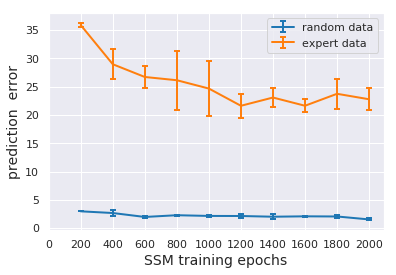

In [238]:
data = np.array(mean_hists)
mean = data.mean(axis=0)
std = data.std(axis=0)
plt.errorbar([(i+1)*200 for i in range(10)],
                 mean[0], yerr=std[0],
                 capsize=3, ecolor=colors[0], linewidth=2, capthick=2, color=colors[0], 
                 label="random data")
plt.errorbar([(i+1)*200 for i in range(10)],
                 mean[1], yerr=std[1],
                 capsize=3, ecolor=colors[1], linewidth=2, capthick=2, color=colors[1], 
                 label="expert data")
plt.xlabel("SSM training epochs", fontsize=14)
plt.xticks([i*200 for i in range(11)], [i*200 for i in range(11)])
plt.ylabel("prediction  error", fontsize=14)
plt.legend(); plt.savefig("trad_wm.png"); # plt.show()

0 1 2 3 4 5 6 7 8 9 3.4451947
0 1 2 3 4 5 6 7 8 9 13.623928
0 1 2 3 4 5 6 7 8 9 2.038654


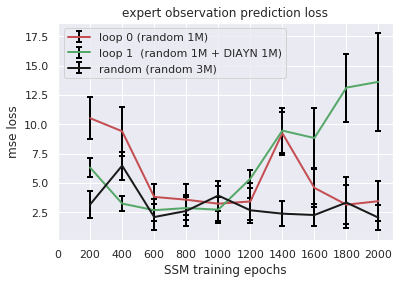

In [169]:
hists = [
    ["Feb28_14-10-06", "../data/loop0_abci/param.pkl", "loop 0 (random 1M)", 'r'],
    ["Feb28_17-33-18", "../data/loop1_abci/param.pkl", "loop 1  (random 1M + DIAYN 1M)", 'g'],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)", 'k']
]
compare_expert_loss_hist(hists, "../data/loop0/test.pkl", N=100, H=10)

0 1 2 3 4 5 6 7 8 9 24.15586
0 1 2 3 4 5 6 7 8 9 44.8794
0 1 2 3 4 5 6 7 8 9 26.495953


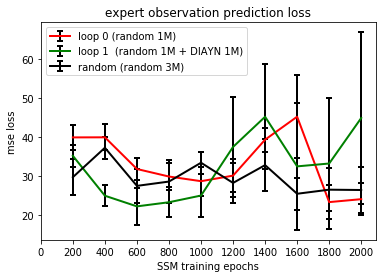

In [122]:
hists = [
    ["Feb28_14-10-06", "../data/loop0_abci/param.pkl", "loop 0 (random 1M)", 'r'],
    ["Feb27_09-34-00", "../data/loop1/param.pkl", "loop 1  (random 1M + DIAYN 1M)", 'g'],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)", 'k']
]
compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=10)

In [136]:
# hists = [
#     ["Feb28_14-10-06", "../data/loop0_abci/param.pkl", "loop 0 (random 1M)", 'r'],
#     ["Feb28_17-33-18", "../data/loop1_abci/param.pkl", "loop 1  (random 1M + DIAYN 1M)", 'g'],
#     ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)", 'k']
# ]
# compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=10, H=300)

In [236]:
# all random 2M
hists = [
    ["MSLr1/weights/temp", "../weights/MSLr1/data/data2M/param.pkl", ""],
    ["MSLr2/weights/temp", "../weights/MSLr2/data/data2M/param.pkl", ""],
    ["MSLr3/weights/temp", "../weights/MSLr3/data/data2M/param.pkl", ""],
    ["MSLr4/weights/temp", "../weights/MSLr4/data/data2M/param.pkl", ""],
]
mean = compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=100, show=False)

0 1 2 3 4 5 6 7 8 9 26.575048
0 1 2 3 4 5 6 7 8 9 25.38375
0 1 2 3 4 5 6 7 8 9 27.822485
0 1 2 3 4 5 6 7 8 9 20.437672


0 1 2 3 4 5 6 7 8 9 25.7517
0 1 2 3 4 5 6 7 8 9 34.771957
0 1 2 3 4 5 6 7 8 9 25.144817


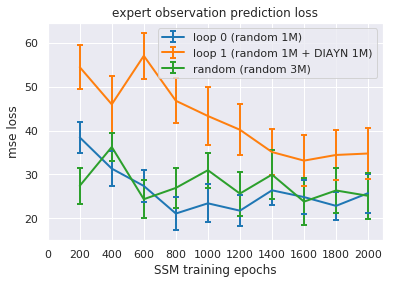

In [209]:
hists = [
    ["MSL2/weights/Mar01_09-11-51", "../../many_msl/MSL2/data/loop0/param.pkl", "loop 0 (random 1M)"],
    ["MSL2/weights/Mar01_11-44-03", "../../many_msl/MSL2/data/loop1/param.pkl", "loop 1 (random 1M + DIAYN 1M)"],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)"]
]
mean = compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=100)

0 1 2 3 4 5 6 7 8 9 23.146494
0 1 2 3 4 5 6 7 8 9 18.651558
0 1 2 3 4 5 6 7 8 9 25.144817


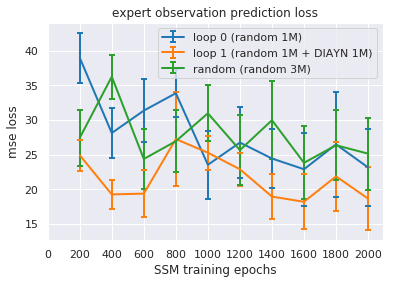

In [210]:
hists = [
    ["MSL3/weights/Mar01_09-03-58", "../../many_msl/MSL3/data/loop0/param.pkl", "loop 0 (random 1M)"],
    ["MSL3/weights/Mar01_11-39-20", "../../many_msl/MSL3/data/loop1/param.pkl", "loop 1 (random 1M + DIAYN 1M)"],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)"]
]
mean = compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=100)

0 1 2 3 4 5 6 7 8 9 26.494665
0 1 2 3 4 5 6 7 8 9 38.628265
0 1 2 3 4 5 6 7 8 9 25.144817


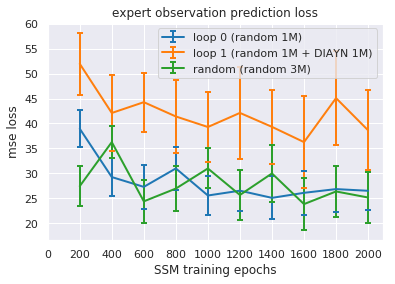

In [211]:
hists = [
    ["MSL4/weights/Mar01_09-05-36", "../../many_msl/MSL4/data/loop0/param.pkl", "loop 0 (random 1M)"],
    ["MSL4/weights/Mar01_11-26-46", "../../many_msl/MSL4/data/loop1/param.pkl", "loop 1 (random 1M + DIAYN 1M)"],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)"]
]
mean = compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=100)

0 1 2 3 4 5 6 7 8 9 26.279306
0 1 2 3 4 5 6 7 8 9 11.389436
0 1 2 3 4 5 6 7 8 9 25.144817


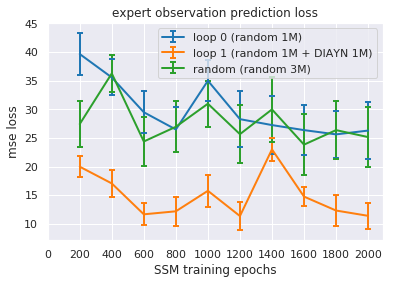

In [212]:
hists = [
    ["MSL5/weights/Mar01_09-06-36", "../../many_msl/MSL5/data/loop0/param.pkl", "loop 0 (random 1M)"],
    ["MSL5/weights/Mar01_11-33-32", "../../many_msl/MSL5/data/loop1/param.pkl", "loop 1 (random 1M + DIAYN 1M)"],
    ["Feb28_22-11-54", "../data/data3M/param.pkl", "random (random 3M)"]
]
mean = compare_expert_loss_hist(hists, "../data/data_expert.pkl", N=100)

### ランダムデータ

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


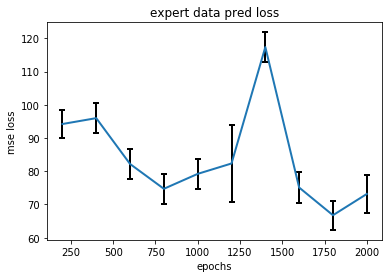

In [20]:
# data1M
timestamp = "Mar01_00-20-11"
param_path = "../data/data1M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


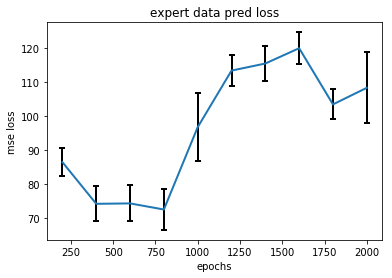

In [21]:
# data2M
timestamp = "Feb28_22-15-11"
param_path = "../data/data2M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


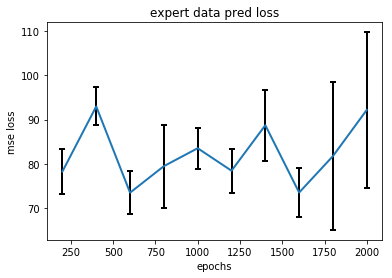

In [22]:
# data3M
timestamp = "Feb28_22-11-54"
param_path = "../data/data3M/param.pkl"
data_path = "../data/data_expert.pkl"
mean_hist, std_hist = [], []

for i in range(10):
    mean, std = eval_expert_loss(timestamp, (i+1)*200, param_path, data_path)
    mean_hist.append(mean)
    std_hist.append(std)

plt.errorbar([(i+1)*200 for i in range(10)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("epochs")
plt.ylabel("mse loss")
plt.show()

### 反復学習

### ランダムデータ

(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)
(100, 301, 6) (100, 301, 17)


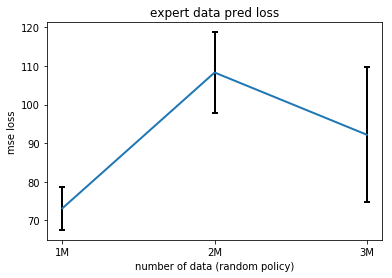

In [17]:
mean_hist = []
std_hist = []
mean, std = eval_expert_loss(
    "Mar01_00-20-11",
    2000,
    "../data/data1M/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb28_22-15-11",
    2000,
    "../data/data2M/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)
mean, std = eval_expert_loss(
    "Feb28_22-11-54",
    2000,
    "../data/data3M/param.pkl",
    "../data/data_expert.pkl"
)
mean_hist.append(mean)
std_hist.append(std)

plt.errorbar([str(i+1)+"M" for i in range(3)],
             mean_hist, yerr=std_hist,
             capsize=3, ecolor="black", linewidth=2, capthick=2)
plt.title("expert data pred loss")
plt.xlabel("number of data (random policy)")
plt.ylabel("mse loss")
plt.show()

### あとは同じランダムデータ数でどうなるか

In [9]:
# random data
timestamp = "Feb26_08-06-04"
param_path = "../data/loop0/param.pkl"
data_path = "../data/loop0/test.pkl"

score = eval_expert_loss(timestamp, 2000, param_path, data_path)
print(score)

 10%|█         | 1/10 [00:00<00:01,  8.50it/s]

(1000, 1000, 6) (1000, 1000, 17)


100%|██████████| 10/10 [00:01<00:00,  7.82it/s]

34.14352
